In [1]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import glob
from gensim.models import Word2Vec
import re
import json
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error, r2_score
import os
import ast
import pickle

In [1]:
relevant_columns=[ 'volume', 'density', 'density_atomic',
       'uncorrected_energy_per_atom', 'energy_per_atom',
       'formation_energy_per_atom', 'energy_above_hull', 'is_stable',
       'band_gap', 
       'efermi', 'is_gap_direct', 'is_metal', 'is_magnetic',
       'ordering', 'total_magnetization_normalized_formula_units']


class FineTuningModel(nn.Module):

    def __init__(self, embedding_weights, hidden_dim, output_dim, num_layers=2, dropout=0.0):
        super(FineTuningModel, self).__init__()
        vocab_size, embedding_dim = embedding_weights.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_weights))
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, lengths):
        x = self.embedding(x)  # Embed the input data
        packed_x = pack_padded_sequence(x, lengths, batch_first=True)
        _, (h_n, _) = self.lstm(packed_x)
        out = self.fc(self.dropout(h_n[-1]))
        return out

def extract_parameters_from_filename(filename):

    gensim_params = re.search(r"vec(\d+)_win(\d+)_mc(\d+)_ep(\d+)_sg(\d+)", filename)
    lstm_params = re.search(r"_hidden(\d+)_layers(\d+)_dropout(\d+\.?\d*)", filename)
    return {
        "gensim": {
            "vector_length": int(gensim_params.group(1)),
            "window_length": int(gensim_params.group(2)),
            "min_count": int(gensim_params.group(3)),
            "epochs": int(gensim_params.group(4)),
            "sg": int(gensim_params.group(5)),
        },
        "lstm": {
            "hidden_layer": int(lstm_params.group(1)),
            "lstm_layers": int(lstm_params.group(2)),
            "dropout": float(lstm_params.group(3)),
        }
    }

class CrystalDataset(Dataset):

    def __init__(self, data):
        self.data = sorted(data, key=lambda x: len(x[0]), reverse=True)  # Sort by sequence length
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(data):

    data.sort(key=lambda x: len(x[0]), reverse=True)
    sequences, targets, compound_ids = zip(*data)
    lengths = [len(seq) for seq in sequences]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    targets = torch.stack(targets)
    return sequences_padded, targets, lengths, compound_ids


def preprocess_data(csv_filepath, model_gen):
    data = []
    print("loading df")
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_filepath)
    print("loaded df")
    # Iterate over the rows of the DataFrame
    for index, row in df.iterrows():
        material_id = row['material_id']  # Get material ID from DataFrame row
        lines = row['content']  # Get content from DataFrame row
        
        properties = properties_df[properties_df['compound_id'] == material_id]
        if not properties.empty:
            properties = properties.iloc[0, 1:]       
        else:
            print(f"No properties found for compound ID: {material_id}")
            continue  # Skip this row and move on to the next one
        
        if properties is not None and not properties.isnull().any():  # Check for None and null values
            indices = []
            for line in ast.literal_eval(lines):
                # Remove unwanted characters (e.g., "\\n", punctuation, etc.) using regular expressions
                line = re.sub(r'[\n\'":=><()]+', '', line)  # Remove \\n from the character class
                words = line.split()
                for word in words:
                    # Check if the word is present in the Word2Vec model vocabulary
                    if word in model_gen.wv.key_to_index:
                        indices.append(model_gen.wv.key_to_index[word])
            if indices:
                indices = torch.tensor(indices, dtype=torch.long)
                try:
                    properties = torch.tensor(properties.values.astype(float), dtype=torch.float)
                    data.append((indices, properties, material_id))
                except ValueError:
                    print(f"Non-numeric data in properties for file {file}")
    return data

def inverse_transform_predicted_df(predicted_file, transformers_dir):
    df_predicted = predicted_file
    with open(f'{transformers_dir}/transformer_types.json', 'r') as f:
        transformer_types = json.load(f)
    df_unscaled = df_predicted.copy()
    for col, transformer_type in transformer_types.items():
        if col in df_predicted.columns:
            if transformer_type == 'standard_scaler' or transformer_type == 'power_transformer' or transformer_type == 'quantile_transformer':
                if os.path.exists(f'{transformers_dir}/{col}_transformer.joblib'):
                    transformer = load(f'{transformers_dir}/{col}_transformer.joblib')
                    df_unscaled[col] = transformer.inverse_transform(df_predicted[[col]])
            elif transformer_type == 'log1p':
                df_unscaled[col] = df_unscaled[col].apply(lambda x: np.expm1(x) if x > 0 else x)
            elif transformer_type == 'label_encoder':
                if df_predicted[col].dtype != 'int64':
                    continue
                if os.path.exists(f'{transformers_dir}/{col}_transformer.joblib'):
                    transformer = load(f'{transformers_dir}/{col}_transformer.joblib')
                    df_unscaled[col] = transformer.inverse_transform(df_predicted[col])
    return df_unscaled


In [ ]:

# 2. Load the models
lstm_model_dir = "trained_lstm_models/"
gensim_model_dir = "trained_gensim_models/"
lstm_model_files = glob.glob(os.path.join(lstm_model_dir, "*vec100_win20_mc1_ep150_sg1_ver12.model_hidden200_layers4_dropout0.1*.pth"))
gensim_model_files = glob.glob(os.path.join(gensim_model_dir, "*.model"))

# 3. Load and preprocess the data
directory = "test_processed_text_files.csv"

test_df_file_name = 'transformers/df_test_properties_transformed.csv'

In [ ]:
# Skip this if you want to directly load the model prediction files for test set
properties_df = pd.read_csv(test_df_file_name)
properties_to_retrieve = ['compound_id'] + relevant_columns
properties_df = properties_df[properties_to_retrieve]
model_performance = []
# 4. Evaluate the models
for lstm_model_file in lstm_model_files:
    print("LSTM model name: ",lstm_model_file)
    lstm_model_name = os.path.basename(lstm_model_file)
    params = extract_parameters_from_filename(lstm_model_name)
    gensim_model_file = next((f for f in gensim_model_files if os.path.basename(f).startswith(lstm_model_name.split("_hidden")[0])), None)
    if gensim_model_file is None:
        print(f"No corresponding Gensim model found for {lstm_model_name}.")
        continue

    gensim_model_name = os.path.basename(gensim_model_file)
    model_gen = Word2Vec.load(gensim_model_file)

    # Get the embeddings from the Gensim model
    embedding_weights_gensim = np.zeros((len(model_gen.wv.key_to_index), model_gen.vector_size))
    for word, idx in model_gen.wv.key_to_index.items():
        embedding_weights_gensim[idx] = model_gen.wv[word]

    # Initialize LSTM model using parameters from the filename
    input_dim = embedding_weights_gensim.shape[1]
    output_dim = 15  
    hidden_dim = params['lstm']['hidden_layer']
    num_layers = params['lstm']['lstm_layers']
    dropout = params['lstm']['dropout']
    model = FineTuningModel(embedding_weights_gensim, hidden_dim, output_dim, num_layers=num_layers, dropout=dropout)
    model.load_state_dict(torch.load(lstm_model_file))
    model.eval()
    print("Loaded model", lstm_model_file)
    
    # Define the directory and filename to save the data
    data_dir = "tensor_datasets/test"
    data_filename = f"{lstm_model_name}_test_data.pkl"
    data_filepath = os.path.join(data_dir, data_filename)

    # Check if the file already exists
    if os.path.isfile(data_filepath):
        # Load the data from the file
        print("Found preprocesed tensor text data")
        with open(data_filepath, 'rb') as f:
            test_data = pickle.load(f)
    else:
        # Preprocess the data and save it to the file
        print("preprocessing data")
        test_data = preprocess_data(directory, model_gen)
        with open(data_filepath, 'wb') as f:
            pickle.dump(test_data, f)
            
    test_dataset = CrystalDataset(test_data)
    test_dataloader = DataLoader(test_dataset, batch_size=128, collate_fn=collate_fn)
    print("loaded dataloader",len(test_data))
 
    all_outputs = []  # Initialize empty list to hold all outputs
    all_compound_ids = []  # Initialize empty list to hold all compound ids

    with torch.no_grad():  # Disable gradient calculation
        print("About to go in to the model")
        for sequences, targets, lengths, compound_ids in test_dataloader:
            outputs = model(sequences, lengths)
            outputs_reshaped = outputs.view(outputs.shape[0], -1)

            all_outputs.append(outputs.detach().numpy())  # Append current batch's outputs
            
            all_compound_ids.extend(compound_ids)  # Append current batch's compound ids

    # Convert list of numpy arrays to single numpy array
    all_outputs = np.concatenate(all_outputs, axis=0)
    # Create a dataframe
    df = pd.DataFrame(all_outputs, columns=relevant_columns)
    df['compound_id'] = all_compound_ids

    output_dir = "transformers"
    transformer_dir = output_dir 
    df_predicted_ = inverse_transform_predicted_df(df, transformer_dir)
df_predicted_.to_csv('test_prediction_transformed.csv', index=False)

# Evaluating quality of test set predictions 

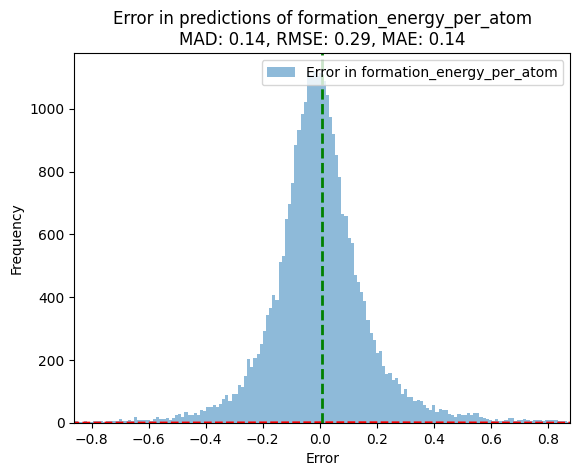

No valid data for column energy_above_hull


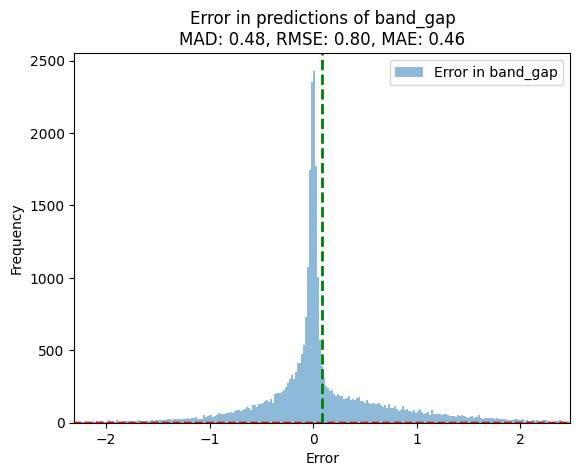

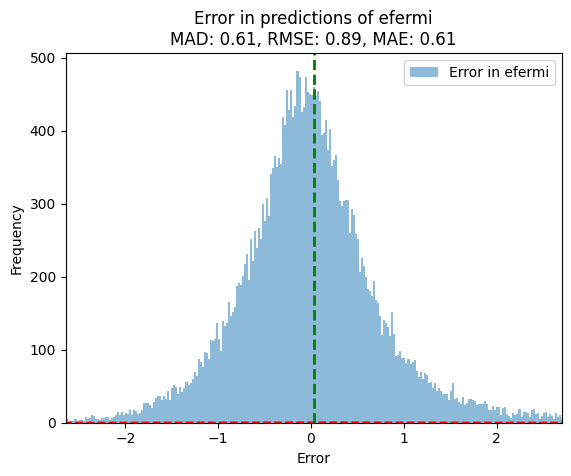

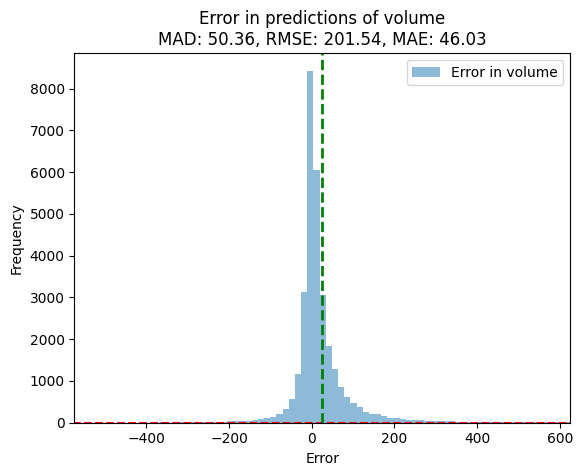

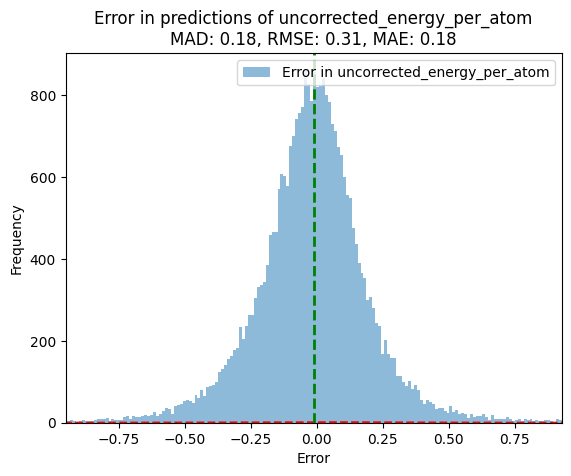

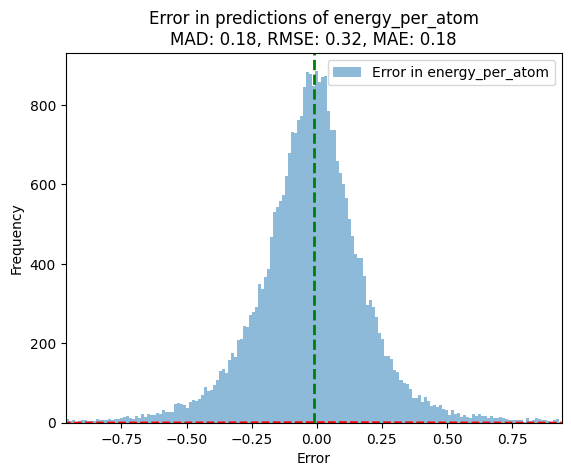

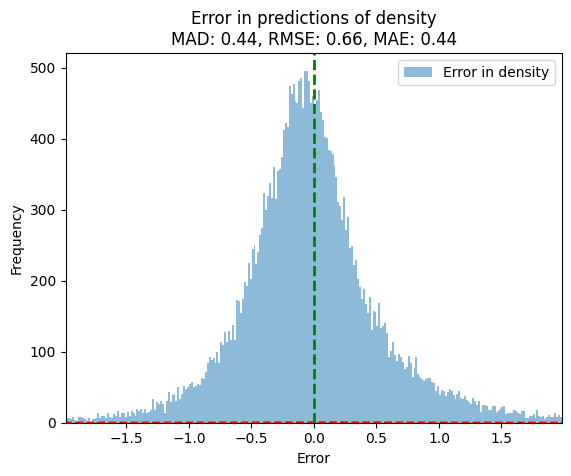

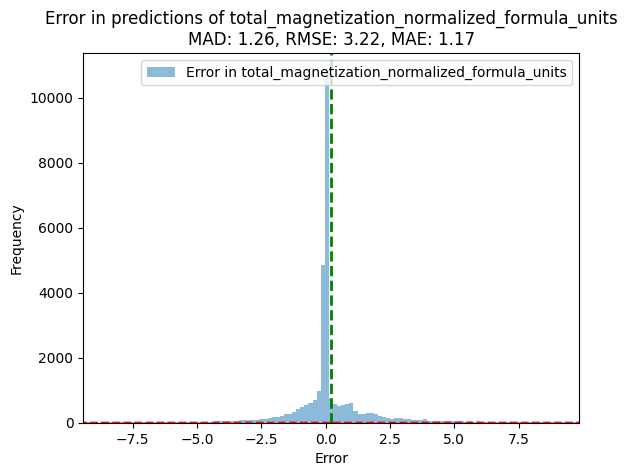

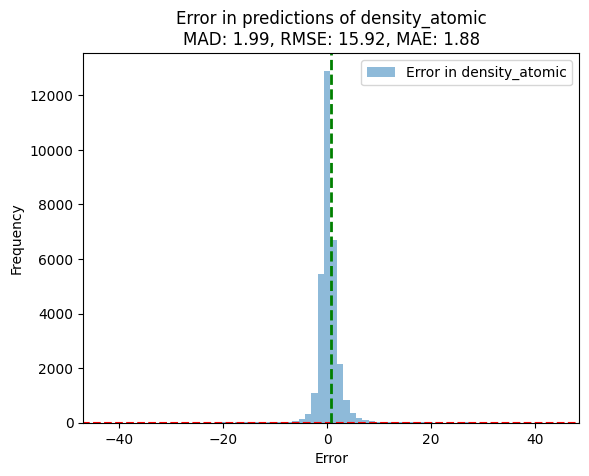

In [2]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

df_predicted=df_predicted_.copy()
df_target=pd.read_csv("properties_test.csv")

df_target.set_index('compound_id', inplace=True)
df_predicted.set_index('compound_id', inplace=True)

# Get the rows of target dataframe that have the same index in the prediction dataframe
df_target_filtered = df_target.loc[df_predicted.index]



# Get the common columns in both dataframes
common_cols = set(df_target_filtered.columns).intersection(df_predicted.columns)

# Select only numeric common columns
numeric_common_cols = df_target_filtered[list(common_cols)].select_dtypes(include=np.number).columns.tolist()

# Perform the subtraction only on numeric common columns
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_difference = df_target_filtered[numeric_common_cols] - df_predicted[numeric_common_cols]

for column in df_difference.columns:
    # Filter out NaN values from the target and predicted columns
    target_values = df_target_filtered[column].dropna()
    predicted_values = df_predicted[column].dropna()

    if len(target_values) !=len(predicted_values) :
        print(f"No valid data for column {column}")
        continue

    # Calculate the mean, MAD, RMSE and MAE
    errors = target_values - predicted_values
    mu = np.mean(errors)
    mad = np.mean(np.abs(errors - mu))
    rmse = np.sqrt(mean_squared_error(target_values, predicted_values))
    mae = mean_absolute_error(target_values, predicted_values)

    # Create histogram
    plt.figure()
    n, bins, patches = plt.hist(errors, bins=1000, density=0, alpha=0.5, label=f'Error in {column}')

    # Add a 'best fit' line for the normal distribution
    y = norm.pdf(bins, mu, np.std(errors))
    plt.plot(bins, y, 'r--')

    # Annotate 1st standard deviation
    plt.axvline(mu, color='green', linestyle='dashed', linewidth=2)

    # Set the x limits to be 4 standard deviations from the mean
    plt.xlim(mu - 3 * np.std(errors), mu + 3 * np.std(errors))

    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title(f'Error in predictions of {column}\nMAD: {mad:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}')
    plt.legend()
    plt.show()


# Parity plots


/tmp/ipykernel_43354/3507420141.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


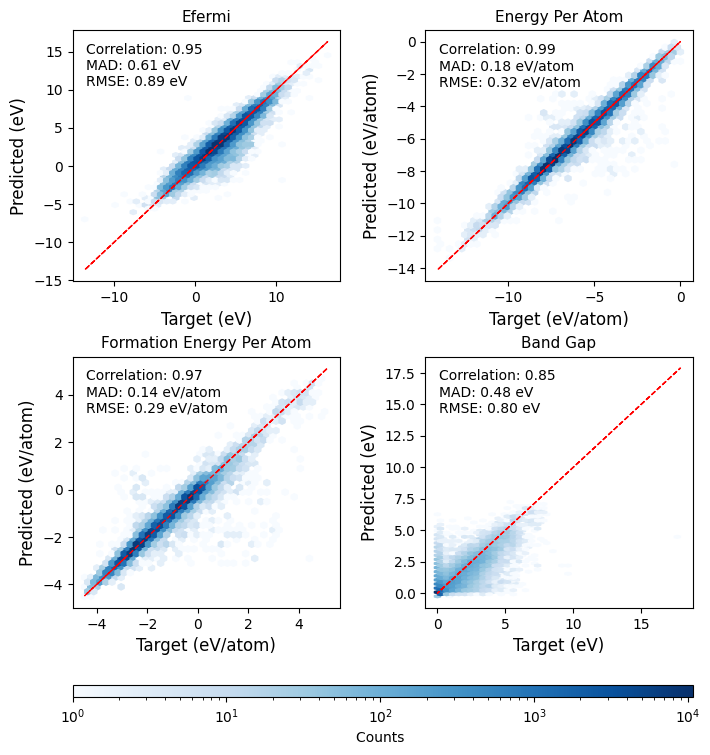

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import mean_squared_error

columns_of_interest = ['efermi', 'energy_per_atom', 'formation_energy_per_atom', 'band_gap']

fig, axs = plt.subplots(2, 2, figsize=(8, 10), gridspec_kw={"hspace": 0.3, "wspace": 0.32
                                                           })

axs = axs.ravel()

units = {
    'efermi': 'eV',
    'energy_per_atom': 'eV/atom',
    'formation_energy_per_atom': 'eV/atom',
    'band_gap': 'eV'
}

for i, column in enumerate(columns_of_interest):
    ax = axs[i]

    # Filter out NaN values from the target and predicted columns
    target_values = df_target_filtered[column].dropna()
    predicted_values = df_predicted[column].dropna()
    
    target_values, predicted_values = target_values.align(predicted_values, join='inner')

    # Calculate the mean, MAD, and RMSE
    errors = target_values - predicted_values
    mu = np.mean(errors)
    mad = np.mean(np.abs(errors - mu))
    rmse = np.sqrt(mean_squared_error(target_values, predicted_values))

    # Calculate the correlation coefficient
    correlation = np.corrcoef(target_values, predicted_values)[0, 1]

    # Hexbin plot
    hb = ax.hexbin(target_values, predicted_values, gridsize=40, cmap='Blues', mincnt=1, norm=LogNorm())

    # y=x line
    ax.plot(target_values, target_values, color='red', linestyle='--', linewidth=1)

    # Set axis labels and title
    ax.set_xlabel(f'Target ({units[column]})', fontsize=12)
    ax.set_ylabel(f'Predicted ({units[column]})', fontsize=12)
    ax.set_title(column.replace("_", " ").title(), fontsize=11)  # Beautify column name

    # Display the statistics on the plot with units
    text_str = f'Correlation: {correlation:.2f}\nMAD: {mad:.2f} {units[column]}\nRMSE: {rmse:.2f} {units[column]}'
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top')#, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Adjust subplot layout and colorbar width
cbar = plt.colorbar(hb, ax=axs, label='Counts ', orientation='horizontal', pad=0.1, aspect=50)
plt.tight_layout()
plt.savefig('Pub_figures/pred_target_hex.jpg', dpi=300,bbox_inches='tight')
plt.show()


# Run the following to generate and save prediction for training set. Otherwise skip and directly load the train set prediction dataframe

In [ ]:
#Loading train set

lstm_model_dir = "trained_lstm_models/"
gensim_model_dir = "trained_gensim_models/"
lstm_model_files = glob.glob(os.path.join(lstm_model_dir, "*vec100_win20_mc1_ep150_sg1_ver12.model_hidden200_layers4_dropout0.1*.pth"))
gensim_model_files = glob.glob(os.path.join(gensim_model_dir, "*.model"))


directory = "train_processed_text_files.csv"

train_df_file_name = '/transformers/df_train_properties_transformed.csv'
properties_df = pd.read_csv(train_df_file_name)

properties_to_retrieve = ['compound_id'] + relevant_columns
properties_df = properties_df[properties_to_retrieve]
model_performance = []
#  Evaluate the models
for lstm_model_file in lstm_model_files:
    print("LSTM model name: ",lstm_model_file)
    lstm_model_name = os.path.basename(lstm_model_file)
    params = extract_parameters_from_filename(lstm_model_name)
    gensim_model_file = next((f for f in gensim_model_files if os.path.basename(f).startswith(lstm_model_name.split("_hidden")[0])), None)
    if gensim_model_file is None:
        print(f"No corresponding Gensim model found for {lstm_model_name}.")
        continue

    gensim_model_name = os.path.basename(gensim_model_file)
    model_gen = Word2Vec.load(gensim_model_file)

    # Get the embeddings from the Gensim model
    embedding_weights_gensim = np.zeros((len(model_gen.wv.key_to_index), model_gen.vector_size))
    for word, idx in model_gen.wv.key_to_index.items():
        embedding_weights_gensim[idx] = model_gen.wv[word]

    # Initialize LSTM model using parameters from the filename
    input_dim = embedding_weights_gensim.shape[1]
    output_dim = 15  # Set this as per your needs
    hidden_dim = params['lstm']['hidden_layer']
    num_layers = params['lstm']['lstm_layers']
    dropout = params['lstm']['dropout']
    model = FineTuningModel(embedding_weights_gensim, hidden_dim, output_dim, num_layers=num_layers, dropout=dropout)
    model.load_state_dict(torch.load(lstm_model_file))
    model.eval()
    print("Loaded model", lstm_model_file)
    
    # Define the directory and filename where you want to save the data
    data_dir = "tensor_datasets/train"
    data_filename = f"{lstm_model_name}_train_data.pkl"
    data_filepath = os.path.join(data_dir, data_filename)

    # Check if the file already exists
    if os.path.isfile(data_filepath):
        # Load the data from the file
        print("Found preprocesed tensor text data")
        with open(data_filepath, 'rb') as f:
            train_data = pickle.load(f)
    else:
        # Preprocess the data and save it to the file
        print("preprocessing data")
        train_data = preprocess_data(directory, model_gen)
        with open(data_filepath, 'wb') as f:
            pickle.dump(train_data, f)
            
    train_dataset = CrystalDataset(train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn)
    print("loaded dataloader",len(train_dataset))
 
    all_outputs = []  # Initialize empty list to hold all outputs
    all_compound_ids = []  # Initialize empty list to hold all compound ids

    with torch.no_grad():  # Disable gradient calculation
        print("About to go in to the model")
        for sequences, targets, lengths, compound_ids in train_dataloader:
            outputs = model(sequences, lengths)
           
            outputs_reshaped = outputs.view(outputs.shape[0], -1)
          

            all_outputs.append(outputs.detach().numpy())  # Append current batch's outputs
            
            all_compound_ids.extend(compound_ids)  # Append current batch's compound ids

    
    all_outputs = np.concatenate(all_outputs, axis=0)
    print(all_outputs.shape)
    # Create a dataframe
    df = pd.DataFrame(all_outputs, columns=relevant_columns)
    df['compound_id'] = all_compound_ids

    #  Scale back the predictions
    output_dir = "transformers"
    transformer_dir = output_dir 
    df_train_predicted_ = inverse_transform_predicted_df(df, transformer_dir)
    


In [9]:
# Run this to save the training prediction
df_train_predicted_.to_csv('train_prediction_transformed.csv', index=False)


# Evaluating catagorical features.


In [2]:
df_train_predicted_ = pd.read_csv('train_prediction_transformed.csv')
df_test_predicted= pd.read_csv('test_prediction_transformed.csv')

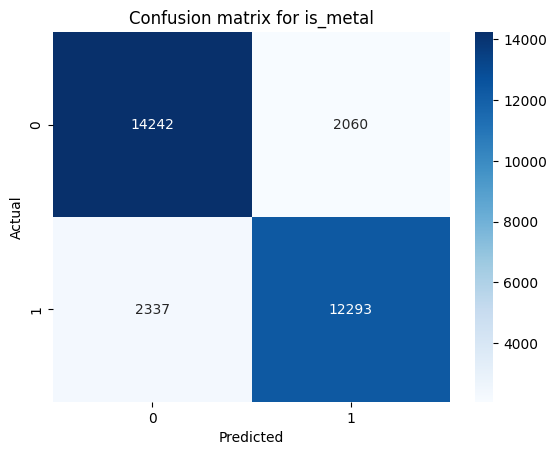

Classification report for is_metal:
               precision    recall  f1-score   support

       False       0.86      0.87      0.87     16302
        True       0.86      0.84      0.85     14630

    accuracy                           0.86     30932
   macro avg       0.86      0.86      0.86     30932
weighted avg       0.86      0.86      0.86     30932

Accuracy for is_metal: 0.8578494762705289




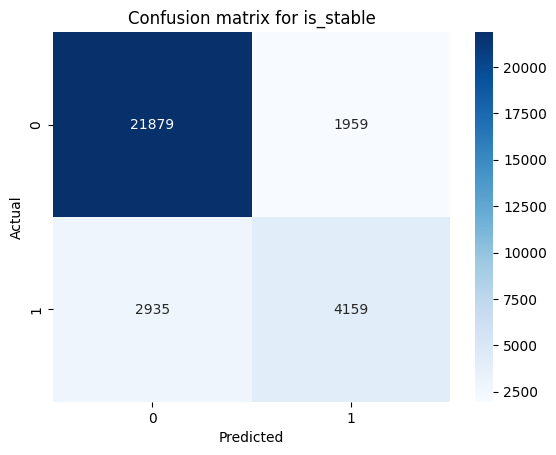

Classification report for is_stable:
               precision    recall  f1-score   support

       False       0.88      0.92      0.90     23838
        True       0.68      0.59      0.63      7094

    accuracy                           0.84     30932
   macro avg       0.78      0.75      0.76     30932
weighted avg       0.84      0.84      0.84     30932

Accuracy for is_stable: 0.8417819733609208




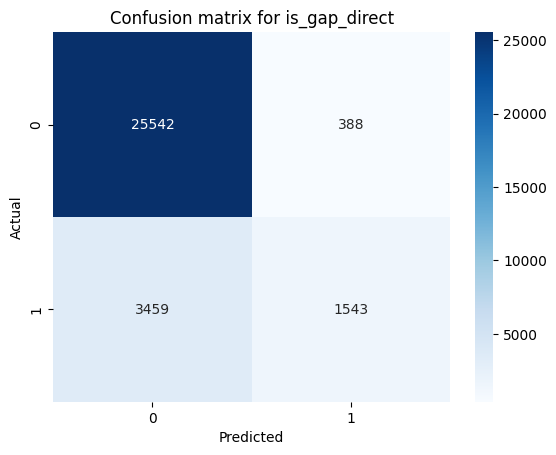

Classification report for is_gap_direct:
               precision    recall  f1-score   support

       False       0.88      0.99      0.93     25930
        True       0.80      0.31      0.45      5002

    accuracy                           0.88     30932
   macro avg       0.84      0.65      0.69     30932
weighted avg       0.87      0.88      0.85     30932

Accuracy for is_gap_direct: 0.8756304151040993




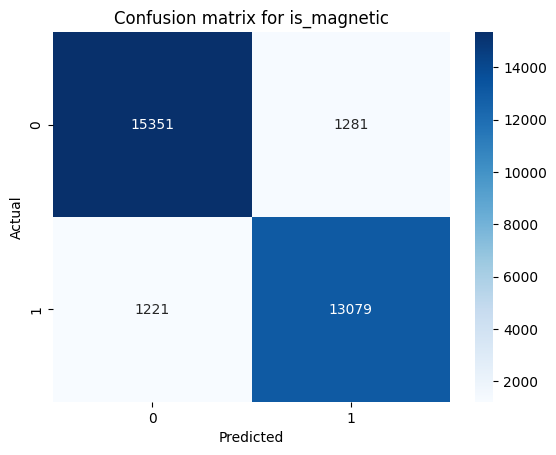

Classification report for is_magnetic:
               precision    recall  f1-score   support

       False       0.93      0.92      0.92     16632
        True       0.91      0.91      0.91     14300

    accuracy                           0.92     30932
   macro avg       0.92      0.92      0.92     30932
weighted avg       0.92      0.92      0.92     30932

Accuracy for is_magnetic: 0.9191128927971033




In [27]:


df_predicted=df_test_predicted.copy()
df_target=pd.read_csv("properties_test.csv")

df_target.set_index('compound_id', inplace=True)
df_predicted.set_index('compound_id', inplace=True)

# Get the rows of target dataframe that have the same index in the prediction dataframe
df_target_filtered = df_target.loc[df_predicted.index]

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the columns for which to compute the confusion matrix
columns = ['is_metal', 'is_stable', 'is_gap_direct', 'is_magnetic']


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Loop over the columns
for col in columns:
    # Apply the threshold of 0.5
    df_predicted[col] = (df_predicted[col] >0.5 ).astype(int)  
    
    # Compute the confusion matrix and visualize it
    cm = confusion_matrix(df_target_filtered[col], df_predicted[col])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion matrix for {col}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Display classification metrics
    report = classification_report(df_target_filtered[col], df_predicted[col])
    print(f"Classification report for {col}:\n", report)
    print(f"Accuracy for {col}: {accuracy_score(df_target_filtered[col], df_predicted[col])}\n\n")


Accuracy: 82.42%
              precision    recall  f1-score   support

          FM       0.77      0.85      0.81     11250
         FiM       0.34      0.30      0.32      2423
          NM       0.94      0.91      0.92     16622
         AFM       0.68      0.23      0.35       627
     Unknown       1.00      0.10      0.18        10

    accuracy                           0.82     30932
   macro avg       0.74      0.48      0.51     30932
weighted avg       0.82      0.82      0.82     30932



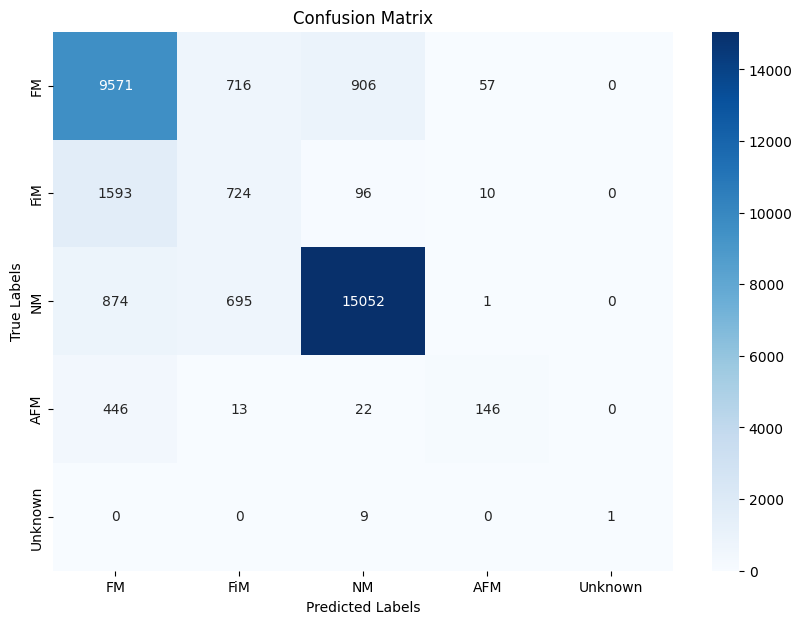

In [29]:
# Copy the original dataframe to prevent unwanted modifications
df_predicted_temp = df_predicted.copy()


df_predicted_temp['ordering_rounded'] = df_predicted_temp['ordering'].round().astype(int)

# Step 2: Map the rounded values to labels
mapping = {
    1: 'FM',
    2: 'FiM',
    3: 'NM',
    0: 'AFM',
    4: 'Unknown'
}

# Map the values and store in a new column
df_predicted_temp['ordering_label'] = df_predicted_temp['ordering_rounded'].map(mapping)

if df_predicted_temp['ordering_label'].isnull().any():
    print("Warning: Some predicted values did not map to any label!")
    print(df_predicted_temp[df_predicted_temp['ordering_label'].isnull()])

# Filter both dataframes for common indices
common_indices = df_target.index.intersection(df_predicted_temp.index)
df_target_filtered = df_target.loc[common_indices]
df_predicted_filtered = df_predicted_temp.loc[common_indices]

# Calculate Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df_target_filtered['ordering'], df_predicted_filtered['ordering_label'])
print(f"Accuracy: {accuracy * 100:.2f}%")

from sklearn.metrics import classification_report
# Calculate the classification report
report = classification_report(df_target_filtered['ordering'], df_predicted_filtered['ordering_label'], labels=list(mapping.values()), target_names=list(mapping.values()))

print(report)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(df_target_filtered['ordering'], df_predicted_filtered['ordering_label'], labels=list(mapping.values()))

# Visualize the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=list(mapping.values()), 
            yticklabels=list(mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
